In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score



In [3]:
df_ordres=pd.read_csv('olist_orders_dataset.csv')

In [4]:
df_customers = pd.read_csv('olist_customers_dataset.csv')

In [5]:
df_payments =pd.read_csv('olist_order_payments_dataset.csv')

In [6]:
#customer_unique_id, nombre_de_commandes, date_depuis_la_derniere_commande, montant_total_client

In [7]:
df_ordres.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [8]:
df_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [9]:
df_payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [10]:
df_ordres=df_ordres[['order_id', 'customer_id', 'order_purchase_timestamp']]
df_customers=df_customers[['customer_id', 'customer_unique_id']]
df_payments=df_payments[['order_id','payment_value']]

In [11]:
# creer une table avec des valeurs order_id unique à partir de la table payment
df_payments=df_payments.groupby('order_id').agg({'payment_value':'sum'})
df_payments.reset_index(level=0, inplace=True)

In [12]:
#creer la table RFM
##réjoindre la tableu df_orders et df_customers dans df_RFM
df_RFM = pd.merge(left=df_ordres, right=df_customers, how='left', on='customer_id')

In [13]:
##réjoindre la tableu df_payment et à la table df_RFM
df_RFM = pd.merge(left=df_RFM, right=df_payments, how='left', on='order_id')

In [14]:
df_RFM.sort_values('order_purchase_timestamp',ascending= False, inplace=True)

In [15]:
df_RFM

,order_id,customer_id,order_purchase_timestamp,customer_unique_id,payment_value
60938,10a045cdf6a5650c21e9cfeb60384c16,a4b417188addbc05b26b72d5e44837a1,2018-10-17 17:30:18,87ab9fec999db8bd5774917de3cdf01c,89.71
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,2018-10-16 20:16:02,262e1f1e26e92e86375f86840b4ffd63,222.03
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,2018-10-03 18:55:29,af5454198a97379394cacf676e1e96cb,197.55
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,2018-10-01 15:30:09,634420a0ea42302205032ed44ac7fccc,80.38
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,2018-09-29 09:13:03,9bb92bebd4cb7511e1a02d5e50bc4655,137.03
...,...,...,...,...,...
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,2016-10-02 22:07:52,0eb1ee9dba87f5b36b4613a65074337c,109.34
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,NaN
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,2016-09-13 15:24:19,009b0127b727ab0ba422f6d9604487c7,40.95
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,2016-09-05 00:15:34,4854e9b3feff728c13ee5fc7d1547e92,75.06


In [16]:
#la fonction qui permet de retourner une base RFM compris entre la Ta et i nombre de semaine après Ta
def Calculer_rfm(df,Ta):
    
#convertir la date donné par l'user au format date
        Ta=pd.to_datetime(Ta,format="%d-%m-%Y")
#changer le type de la colonne date en type datetime
        df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors = 'coerce')
    
# trier les lignes en fonctions de la colonne date
        df.sort_values('order_purchase_timestamp',ascending= False, inplace=True)

#toutes les lignes jusqu'a à une date    
        df=df[df['order_purchase_timestamp'] <= Ta]
#regrouper les commandes en fonction de client
        df=df.groupby('customer_unique_id').agg({'order_id':'count','payment_value':'sum','order_purchase_timestamp':'first'})
        df.reset_index(level=0, inplace=True) 
        df.drop(['customer_unique_id'], axis=1, inplace=True)

#renommer la colonne order id en nombre de commande
        df.rename(columns={'order_id':'nbr_orders'},inplace=True)                
# créer une nouvelle colonne date dif
       # df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors = 'coerce')
        df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
        Ta=pd.to_datetime(Ta)
        df['date_diff']= df['order_purchase_timestamp'].apply(lambda date: Ta - date )

# prendre uniquement les jours
        df['date_diff']=df['date_diff'].apply(lambda date: date.days)

        df.drop(['order_purchase_timestamp'], axis=1, inplace=True)

        
        return df

In [17]:
#RFM jusqu'à Ta 
df_ta =Calculer_rfm(df_RFM,'01-01-2018')


In [18]:


scaler0 = StandardScaler()
scaler0.fit(df_ta)
df_ta_S0 = scaler0.transform(df_ta)


In [19]:

model0 =  KMeans(n_clusters= 4)
model0.fit(df_ta_S0)
C0=model0.predict(df_ta_S0)


In [20]:
##boucle permet d'ajouter le nombre de semaine


# i allant de 1 à 10
date_debut = pd.to_datetime('01-01-2018',format="%d-%m-%Y")
tab=[]
for i in range(1,40):
    df_ta1s =Calculer_rfm(df_RFM,date_debut + timedelta(weeks=i))
    df_ta1s_S1=scaler0.transform(df_ta1s)
    
    C_init= model0.predict(df_ta1s_S1)

    model =KMeans(n_clusters= 4)
    model.fit(df_ta1s_S1)
    C_new = model.predict(df_ta1s_S1)
    
    ari =adjusted_rand_score(C_init,C_new)
    tab.append(ari)
print(tab)

#couvrir toute la période de 

[0.963682522040397, 0.947247792126977, 0.928399013296557, 0.8933717563296693, 0.8855480650569858, 0.866806017488968, 0.826763311231075, 0.8015733570269422, 0.7876088740138161, 0.7638526887616679, 0.7362548668801413, 0.7286326372588102, 0.7092872591317904, 0.696742862552956, 0.6796455822845638, 0.6508961441331259, 0.6199219415525721, 0.5265190192624973, 0.4948341492244865, 0.4777739416157437, 0.45786362808540443, 0.44557481470781213, 0.43932504143667245, 0.4129236745671205, 0.387492209499696, 0.36577031136349164, 0.3433034748876451, 0.3208437474339638, 0.3058464087588861, 0.29299759409237874, 0.28595891190576067, 0.38422862520773854, 0.39143185603521075, 0.37430218822609546, 0.34596691858088185, 0.3174799438581677, 0.2958825645991799, 0.26658747925590565, 0.24304560435664027]


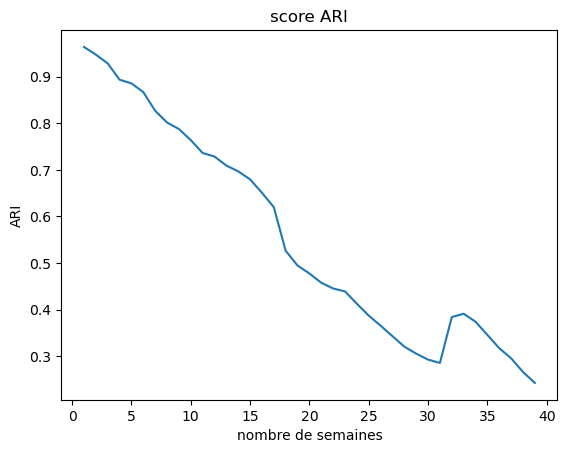

In [21]:
plt.plot(range(1,40),tab)
plt.title("score ARI")
plt.xlabel("nombre de semaines")
plt.ylabel("ARI")
plt.show()


==> notre segmentation clients est fiable pour une durée de 9 semaines en vue d'analyse de raphe de score ARI, nous préconisant un rénouvellement d'analyses tous les 8 semaines. 